In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pickle

from Frank_Wolfe.DFW import *
from Frank_Wolfe.utils import *

In [2]:
save_stats = True
save_figs = True

In [3]:
def accuracy(predicted_logits, reference):
    """
    Compute the ratio of correctly predicted labels
    :param predicted_logits: float32 tensor of shape (batch size, num classes)
                        The logits predicted by the model
    :param reference: int64 tensor of shape (batch_size) with the class number
                        Ground-truth labels
    :return: accuracy: float
    """

    labels = torch.argmax(predicted_logits, 1)
    correct_predictions = labels.eq(reference)
    return correct_predictions.sum().float() / correct_predictions.nelement()

In [4]:
# we download and normalize the datasets

ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
mnist_testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)

In [5]:
batch_size = 1000

# we import the dataloaders

dataset_test = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=False, download=True, transform=torchvision.transforms.ToTensor()), 
  batch_size=100,
  shuffle=True
)
dataset_train = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=True, download=True, transform=torchvision.transforms.ToTensor()),
  batch_size=batch_size,
  shuffle=True
)

In [6]:
input_size = 28*28
hidden_size = 1500
output_size = 10

In [7]:
# model architecture definition

class MultiLayerPerceptron(torch.nn.Module):
    
    # fully connected neural network with 2 hidden layers with 1500 neurons each. We use ReLU activation functions
    
    def __init__(self):
        super(MultiLayerPerceptron,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.relu = nn.ReLU()
        self.fc_in = nn.Linear(self.input_size,self.hidden_size,bias=True) # fully connected input_layer
        self.fc_hid_1 = nn.Linear(self.hidden_size,self.hidden_size,bias=True) # fully connected hidden_layer_1
        self.fc_hid_2 = nn.Linear(self.hidden_size,self.hidden_size,bias=True) # fully connected hidden_layer_2
        self.fc_out = nn.Linear(self.hidden_size,self.output_size,bias=True)
    
    def forward(self,x):
        batch_size = x.shape[0]
        x = x.view(batch_size, self.input_size)
        x = self.relu(self.fc_in(x))
        x = self.relu(self.fc_hid_1(x))
        x = self.relu(self.fc_hid_2(x))
        x = self.fc_out(x)
        return x

In [8]:
#initialize the model
mlp = MultiLayerPerceptron()

In [9]:
learning_rate = 0.001

cross_entropy = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [10]:
def train_model(model, dataset_train, dataset_test, optimizer, criterion, epochs, scheduler, lr_decrease=True):
    """
    The function is used to train the neural network
    :param model: <class '__main__.MultiLayerPerceptron'>
                    The model we wish to train
    :param dataset_train: <class 'torch.utils.data.dataloader.DataLoader'>
                    The train pytorch dataloader
    :param dataset_test: <class 'torch.utils.data.dataloader.DataLoader'>
                    The test pytorch dataloader
    :param optimizer: <class 'torch.optim.sgd.SGD'>
                    The used pytorch optimizer
    :param criterion: <class 'torch.nn.modules.loss.CrossEntropyLoss'>
                    The loss used during the training
    :param epochs: int
                    The number of epochs
    :return: train losses, accuracies: lists of training losses and test accuracies respectively
    """
    train_losses = []
    accuracies = []
    
    for epoch in range(epochs): # loop over the dataset multiple times
        epoch_loss = 0.0 
        model.train()
        running_loss = 0
        n_steps =0
        for batch_x,batch_y in dataset_train:
            n_steps = n_steps+1
            # batch_x,batch_y = batch_x.to(device),batch_y.to(device)

            #Get output and evaluate with loss function
            predictions = model(batch_x)
            loss = criterion(predictions,batch_y)
            running_loss += loss.item() * len(batch_y)
    
            #Initialize optimizer
            optimizer.zero_grad()
            loss.backward()

            #Update the network
            optimizer.step()
            
        running_loss = running_loss / n_steps
        train_losses.append(running_loss)
        
        #Test the quality on the test set
        model.eval()
        accuracies_test = []
        
        for batch_x, batch_y in dataset_test:
            # batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Evaluate the network (forward pass)
            prediction = model(batch_x)
            accuracies_test.append(accuracy(prediction, batch_y))
    
        print("Epoch {} | Test accuracy: {:.5f}".format(epoch, sum(accuracies_test).item()/len(accuracies_test)))
        
        accuracies.append(sum(accuracies_test).item()/len(accuracies_test))
    return train_losses, accuracies

In [11]:
num_epochs = 100

start = time.time()

#train using DFW
train_losses, accuracies_test = train_model(mlp, dataset_train, dataset_test, optimizer, cross_entropy, num_epochs, scheduler)

end = time.time()
print('\n')
print('The total time spent is', end - start)

Epoch 0 | Test accuracy: 0.10290
Epoch 1 | Test accuracy: 0.10290
Epoch 2 | Test accuracy: 0.10330
Epoch 3 | Test accuracy: 0.10380
Epoch 4 | Test accuracy: 0.10720
Epoch 5 | Test accuracy: 0.11610
Epoch 6 | Test accuracy: 0.13150
Epoch 7 | Test accuracy: 0.14740
Epoch 8 | Test accuracy: 0.16240
Epoch 9 | Test accuracy: 0.17360
Epoch 10 | Test accuracy: 0.18530
Epoch 11 | Test accuracy: 0.19700
Epoch 12 | Test accuracy: 0.21060
Epoch 13 | Test accuracy: 0.22470
Epoch 14 | Test accuracy: 0.23790
Epoch 15 | Test accuracy: 0.25240
Epoch 16 | Test accuracy: 0.26660
Epoch 17 | Test accuracy: 0.28100
Epoch 18 | Test accuracy: 0.29900
Epoch 19 | Test accuracy: 0.31600
Epoch 20 | Test accuracy: 0.33490
Epoch 21 | Test accuracy: 0.35270
Epoch 22 | Test accuracy: 0.36920
Epoch 23 | Test accuracy: 0.38400
Epoch 24 | Test accuracy: 0.40100
Epoch 25 | Test accuracy: 0.41550
Epoch 26 | Test accuracy: 0.43060
Epoch 27 | Test accuracy: 0.44350
Epoch 28 | Test accuracy: 0.45660
Epoch 29 | Test accuracy

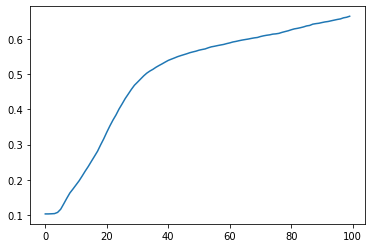

In [14]:
plt.plot(np.arange(num_epochs), accuracies_test)

In [15]:
current_dict = {'epochs': num_epochs, 'train_losses': train_losses, 'test_accuracies': accuracies_test}
SGD_results = {}
SGD_results.update({'SGD': current_dict})

In [16]:
# save everything onto file
if save_stats: 
    output_folder = os.path.join(os.getcwd(), 'results')  # set the folder
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_DFW.pkl'
    with open(fname, 'wb') as handle:
        pickle.dump(SGD_results, handle, protocol=pickle.HIGHEST_PROTOCOL)